# CLUSTER diario

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns; sns.set()

In [2]:
from datetime import datetime
def fechas(x):
    x = datetime.strptime(x, '%m-%d-%Y %I:%M %p')
    return x

In [3]:
patient_0_RN = pd.read_csv('patient0.csv')
patient_0_RN.dropna(inplace = True)
patient_0_RN.reset_index(drop=True, inplace=True)
patient_0_RN.head()

patient_0_RN['DATES'] = patient_0_RN['DATE'].apply(fechas)
patient_0_RN.drop('DATE', axis = 1, inplace = True)
patient_0_RN.head()

patient_0_RN.rename(columns={' LEVEL':'LEVEL'}, inplace=True)

patient_0_RN.sort_values('DATES', ascending=True, inplace=True)
patient_0_RN.drop_duplicates(inplace=True)
patient_0_RN.head()

,LEVEL,DATES
85599,194.0,2016-08-24 15:20:00
85600,164.0,2016-08-24 15:35:00
85601,126.0,2016-08-24 15:50:00
85602,87.0,2016-08-24 16:05:00
85603,65.0,2016-08-24 16:20:00


In [4]:
import datetime

In [5]:
split_date = datetime.datetime(year=2018, month=8, day=1)
df_train  = patient_0_RN.loc[patient_0_RN['DATES']<split_date]
df_test = patient_0_RN.loc[patient_0_RN['DATES']>=split_date]
print('Shape of train:', df_train.shape)
print('Shape of test:', df_test.shape)

Shape of train: (57751, 2)
Shape of test: (18363, 2)


In [6]:
df_train.sort_values('DATES', ascending=True, inplace=True)
df_test.sort_values('DATES', ascending=True, inplace=True)

#Reset the indices of the validation set
df_test.reset_index(drop=True, inplace=True)

#Reset the indices of the train set
df_train.reset_index(drop=True, inplace=True)

c:\users\jbart\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\jbart\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
# Vamos a DIVIDIR (no agrupar) al paciente 0 por cada dia

In [8]:
# Vemos que la mayoría de los días tienen 88 o mas mediciones
df_train.loc[:,"day"] = df_train.DATES.dt.floor("d")
df_train.groupby("day").size().value_counts()

c:\users\jbart\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\jbart\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


95     233
96     222
94      33
92      16
91      15
93      14
87      11
88      10
97       8
83       6
89       6
86       4
84       3
28       3
90       3
85       3
55       2
81       2
79       2
35       2
71       2
27       2
100      2
82       2
80       1
77       1
101      1
34       1
52       1
54       1
57       1
60       1
61       1
62       1
63       1
70       1
117      1
73       1
74       1
118      1
dtype: int64

In [9]:
df_test.loc[:,"day"] = df_test.DATES.dt.floor("d")
df_test.groupby("day").size().value_counts()

95     71
96     68
94     21
93      6
90      5
89      4
61      2
92      2
91      2
87      2
86      2
83      2
78      1
71      1
72      1
76      1
103     1
80      1
84      1
100     1
88      1
dtype: int64

In [10]:
# Vamos a DIVIDIR (no agrupar) al paciente 0 por cada semana

In [11]:
# 565 superan el punto de corte
cutoff = 88
(df_train.groupby("day").size() >= cutoff).sum() 

565

In [12]:
# 182 superan el punto de corte
cutoff = 88
(df_test.groupby("day").size() >= cutoff).sum() 

182

In [13]:
# de un total de 622 dias
# Es suficientemente grande, perdemos un 20% aprox
df_train.day.nunique()

622

In [14]:
df_test.day.nunique()

196

In [15]:
dias_buenos = (df_train.groupby("day").size() >= cutoff).reset_index(name="ok").query("ok").day
df_train = df_train.loc[df_train.day.isin(dias_buenos),:].reset_index(drop=True)

In [16]:
dias_buenos2 = (df_test.groupby("day").size() >= cutoff).reset_index(name="ok").query("ok").day
df_test = df_test.loc[df_test.day.isin(dias_buenos2),:].reset_index(drop=True)

In [17]:
# Hacemos una muestra cada 15 min para alinear todas las series temporales
df_train_day_series = df_train.set_index(df_train.DATES).LEVEL.resample("15Min").mean()

df_train_day_series = pd.DataFrame({"level":df_train_day_series}).reset_index()

df_train_day_series.loc[:,"day"] = df_train_day_series.DATES.dt.floor("d")
df_train_day_series.loc[:,"offset"] =df_train_day_series.DATES - df_train_day_series.day

In [18]:
# Hacemos una muestra cada 15 min para alinear todas las series temporales
df_test_day_series = df_test.set_index(df_test.DATES).LEVEL.resample("15Min").mean()

df_test_day_series = pd.DataFrame({"level":df_test_day_series}).reset_index()

df_test_day_series.loc[:,"day"] = df_test_day_series.DATES.dt.floor("d")
df_test_day_series.loc[:,"offset"] =df_test_day_series.DATES - df_test_day_series.day

In [19]:
df_train_day_series = df_train_day_series.loc[~df_train_day_series.level.isna(),:]

In [20]:
df_test_day_series = df_test_day_series.loc[~df_test_day_series.level.isna(),:]

In [21]:
df_train_day_pivoted = df_train_day_series.pivot(columns="offset",index="day",values="level")

In [22]:
df_test_day_pivoted = df_test_day_series.pivot(columns="offset",index="day",values="level")

In [23]:
df_train_day_pivoted = df_train_day_pivoted.interpolate(axis=1).fillna(method="ffill",axis=1).fillna(method="bfill",axis=1)

In [24]:
df_test_day_pivoted = df_test_day_pivoted.interpolate(axis=1).fillna(method="ffill",axis=1).fillna(method="bfill",axis=1)

In [25]:
df_train_day_pivoted.shape

(565, 96)

In [26]:
df_test_day_pivoted.shape

(182, 96)

In [27]:
# Cada fila es un dia
# Cada columna es un momento del día. Esto es el "perfil del día" y es lo que hay que clusterizar
df_train_day_pivoted

offset,0 days 00:00:00,0 days 00:15:00,0 days 00:30:00,0 days 00:45:00,0 days 01:00:00,0 days 01:15:00,0 days 01:30:00,0 days 01:45:00,0 days 02:00:00,0 days 02:15:00,...,0 days 21:30:00,0 days 21:45:00,0 days 22:00:00,0 days 22:15:00,0 days 22:30:00,0 days 22:45:00,0 days 23:00:00,0 days 23:15:00,0 days 23:30:00,0 days 23:45:00
day,,,,,,,,,,,,,,,,,,,,,
2016-08-25,191.0,195.0,205.0,209.0,208.0,209.0,213.0,218.0,215.0,209.0,...,332.0,332.0,332.0,336.0,315.0,290.0,269.0,245.0,217.0,190.0
2016-08-26,168.0,161.0,160.0,159.5,159.0,157.0,154.0,152.0,152.0,145.0,...,275.0,297.0,320.0,327.0,310.0,288.0,248.0,207.0,178.0,156.0
2016-08-27,140.0,132.0,132.0,137.0,141.0,137.0,127.0,133.0,142.0,144.0,...,351.0,366.0,381.0,383.0,359.0,333.0,299.0,260.0,228.0,221.0
2016-08-28,240.0,252.0,257.0,262.0,273.0,285.0,290.0,288.0,289.0,299.0,...,342.0,363.0,371.0,346.0,288.0,213.0,140.0,104.0,91.0,84.0
2016-08-29,73.0,71.0,79.0,93.0,114.0,138.0,160.0,176.0,187.0,196.0,...,262.0,277.0,274.0,246.0,199.0,154.0,132.0,119.0,108.0,109.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-27,74.0,58.0,40.0,40.0,40.0,41.0,53.0,93.0,97.0,86.0,...,165.0,160.0,158.0,167.0,184.0,209.0,250.0,285.0,302.0,292.0
2018-07-28,257.0,203.0,139.0,97.0,74.0,77.0,87.0,84.0,78.0,80.0,...,128.0,131.0,141.0,151.0,154.0,156.0,147.0,130.0,119.0,128.0
2018-07-29,133.0,132.0,153.0,184.0,204.0,219.0,233.0,242.0,243.0,250.0,...,73.0,58.0,48.0,50.0,80.0,112.0,115.0,96.0,77.0,64.0


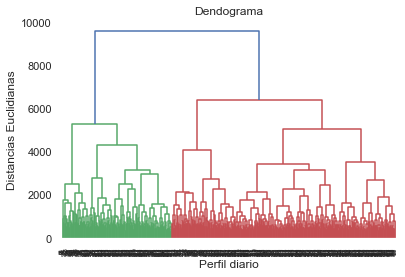

In [55]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(df_train_day_pivoted, method = 'ward'))

fig.set_size_inches(18.5, 10.5)
plt.title('Dendograma')
plt.xlabel('Perfil diario')
plt.ylabel('Distancias Euclidianas')
plt.show()

c:\users\jbart\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


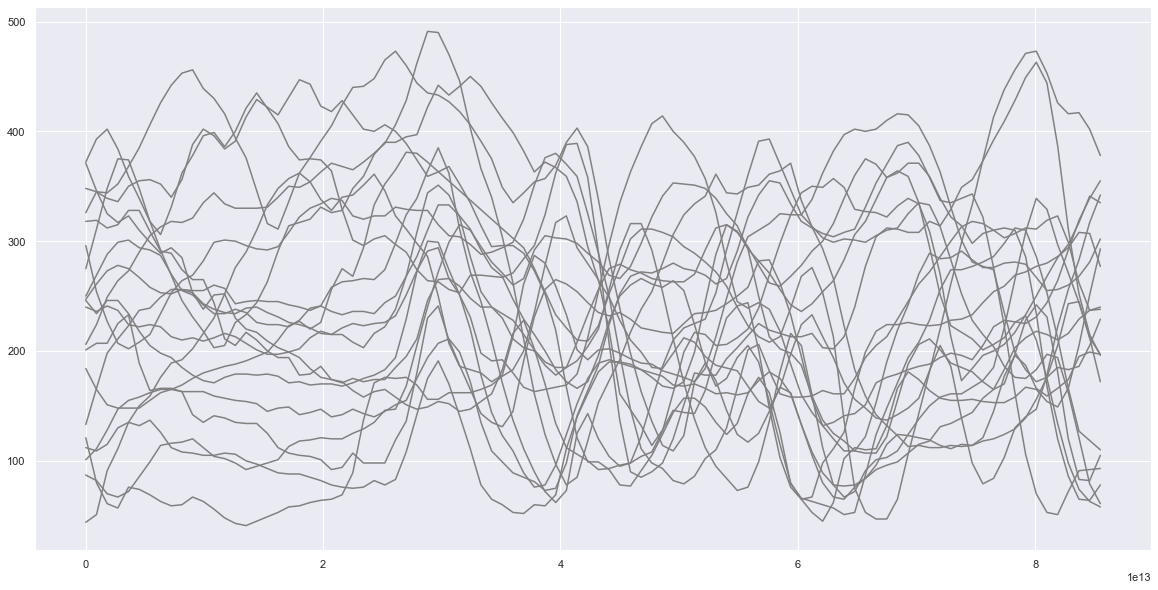

In [28]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
fig.show()
for i in range(20,40):
    plt.plot(df_train_day_pivoted.iloc[i,:] , c="grey")
plt.draw()

c:\users\jbart\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


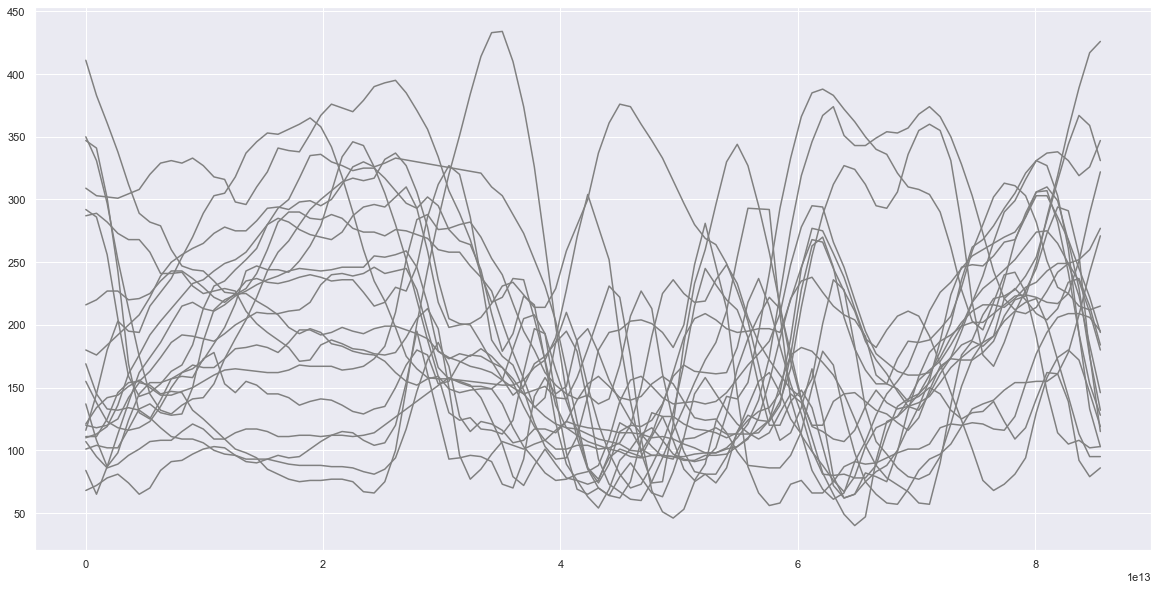

In [29]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(20,10))
fig.show()
for i in range(20,40):
    plt.plot(df_test_day_pivoted.iloc[i,:], c="grey")
plt.draw()

## Ploteos correctos

In [87]:
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

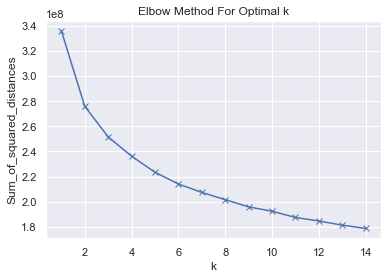

In [88]:
ssd = []
K= range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_train_day_pivoted)
    ssd.append(km.inertia_)

plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

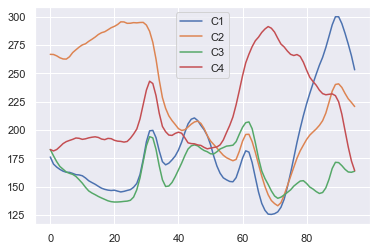

In [92]:
clusters = 4
kmeans = KMeans(n_clusters=clusters).fit(df_train_day_pivoted)
centroids = kmeans.cluster_centers_

fig = plt.figure() 

for i in range(centroids.shape[0]):
    plt.plot(centroids[i,:], label=f"C{i+1}")
plt.legend()
plt.draw()


In [93]:
def pintar_cluster(df_train_day_pivoted, kmeans, cluster, max_lines=None):
    x_axis = range(df_test_day_pivoted.shape[1])
    fig = plt.figure()
    plt.title(f"Cluster {cluster}")
    cluster_data = df_train_day_pivoted.loc[kmeans.labels_ == cluster,:]
    if max_lines is not None:
        to_plot = cluster_data.sample(frac = 1).iloc[:max_lines,:]        
    else:
        to_plot = cluster_data
    for i in range(to_plot.shape[0]):
        plt.plot(x_axis, to_plot.iloc[i,:], color="grey", alpha=0.2)
    centroid = kmeans.cluster_centers_[cluster,:]
    plt.plot(x_axis, centroid, color="blue")
    plt.draw()

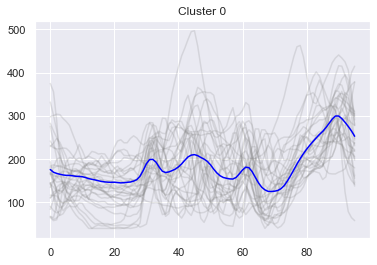

In [99]:
pintar_cluster(df_train_day_pivoted, kmeans, 0, max_lines=30)

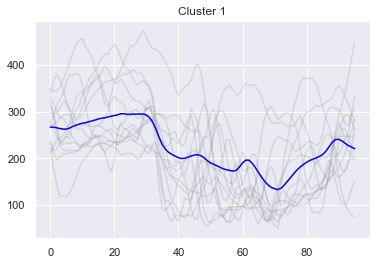

In [110]:
pintar_cluster(df_train_day_pivoted, kmeans, 1, max_lines=13)

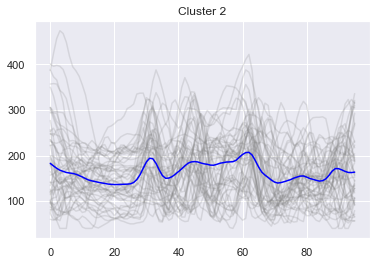

In [100]:
pintar_cluster(df_train_day_pivoted, kmeans, 2, max_lines=50)

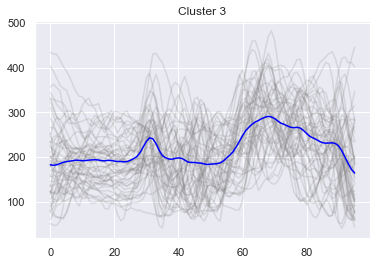

In [102]:
pintar_cluster(df_train_day_pivoted, kmeans, 3, max_lines=50)

# DTW

In [31]:
from tslearn.clustering import TimeSeriesKMeans
import tqdm

100%|██████████| 9/9 [39:55<00:00, 266.15s/it]


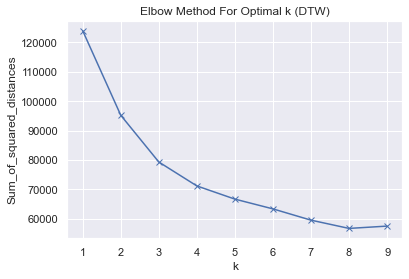

In [32]:
dtw_models = []
ssd = []
K = range(1,10)
for k in tqdm.tqdm(K):
    km = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=100, n_jobs=-1)
    km = km.fit(df_train_day_pivoted)
    dtw_models.append(km)
    ssd.append(km.inertia_)

plt.plot(K, ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k (DTW)')
plt.show()

In [33]:
def pintar_centroides(model, cluster=None):
    fig = plt.figure()
    ks = range(model.cluster_centers_.shape[0]) if cluster is None else [cluster]
    for i in ks:
        plt.plot(model.cluster_centers_[i].flatten(), label=f"C{i+1}")
    plt.legend()
    plt.draw()
    
# Medimos la distancia al cluster y tomamos el top 15
def pintar_cluster_dtw_closest(df, model, cluster, max_lines=10):
    distancias_a_cluster = np.min(model.transform(df), axis=1)
    labels = model.labels_

    top_closest = np.argsort(distancias_a_cluster[labels == cluster])[:max_lines]
    lines_closest = df_train_day_pivoted.iloc[labels==cluster,:].iloc[top_closest,:]

    x_axis = range(lines_closest.shape[1])
    fig = plt.figure()

    plt.title(f"Cluster {cluster}")
    for i in range(lines_closest.shape[0]):
        plt.plot(x_axis, lines_closest.iloc[i,:], color="grey", alpha=0.2)
    plt.draw()

# Pinta lineas al azar del cluster
def pintar_cluster_dtw(df, model, cluster, max_lines=None):
    x_axis = range(df.shape[1])
    fig = plt.figure()
    plt.title(f"Cluster {cluster}")
    cluster_data = df.loc[model.labels_ == cluster,:]
    if max_lines is not None:
        to_plot = cluster_data.sample(frac = 1).iloc[:max_lines,:]        
    else:
        to_plot = cluster_data
    for i in range(to_plot.shape[0]):
        plt.plot(x_axis, to_plot.iloc[i,:], color="grey", alpha=0.2)
    plt.draw()


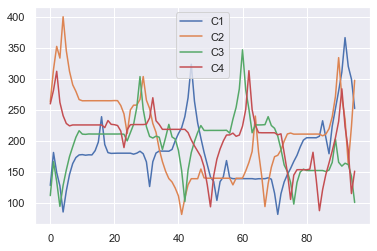

In [57]:
pintar_centroides(dtw_models[3])

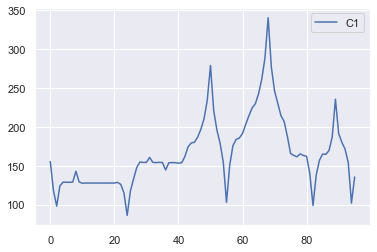

In [58]:
pintar_centroides(dtw_models[5],0)

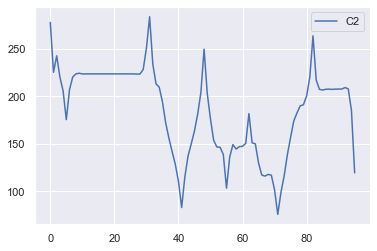

In [59]:
pintar_centroides(dtw_models[5],1)

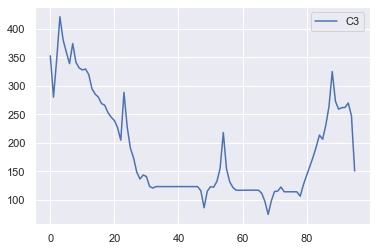

In [60]:
pintar_centroides(dtw_models[5],2)

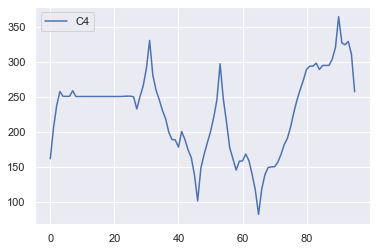

In [61]:
pintar_centroides(dtw_models[5],3)

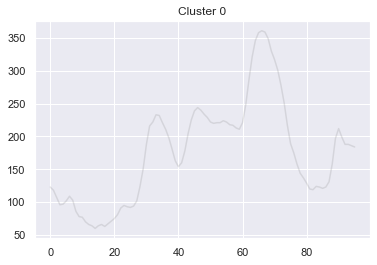

In [36]:
pintar_cluster_dtw(df_train_day_pivoted, dtw_models[5], 0, max_lines=1)

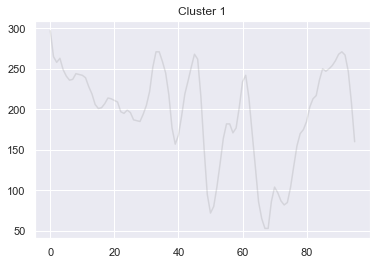

In [37]:
pintar_cluster_dtw(df_train_day_pivoted, dtw_models[5], 1, max_lines=1)

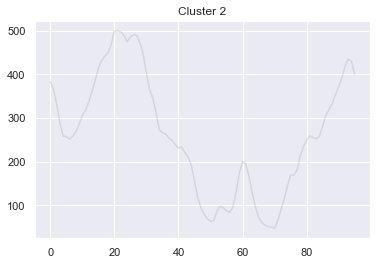

In [38]:
pintar_cluster_dtw(df_train_day_pivoted, dtw_models[5], 2, max_lines=1)

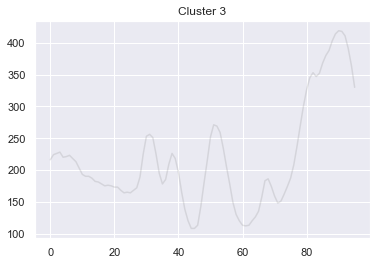

In [39]:
pintar_cluster_dtw(df_train_day_pivoted, dtw_models[5], 3, max_lines=1)

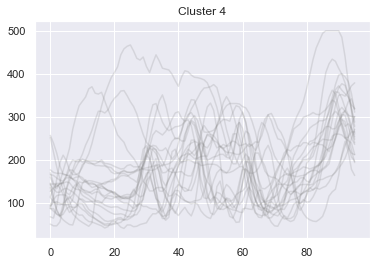

In [40]:
pintar_cluster_dtw(df_train_day_pivoted, dtw_models[5], 4, max_lines=20)

c:\users\jbart\anaconda3\lib\site-packages\tslearn\utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 565 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


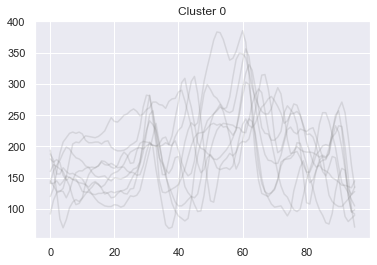

In [41]:
pintar_cluster_dtw_closest(df_train_day_pivoted, dtw_models[5], cluster=0, max_lines=9)

c:\users\jbart\anaconda3\lib\site-packages\tslearn\utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 565 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


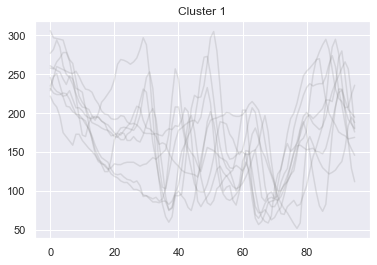

In [42]:
pintar_cluster_dtw_closest(df_train_day_pivoted, dtw_models[5], cluster=1, max_lines=9)

c:\users\jbart\anaconda3\lib\site-packages\tslearn\utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 565 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


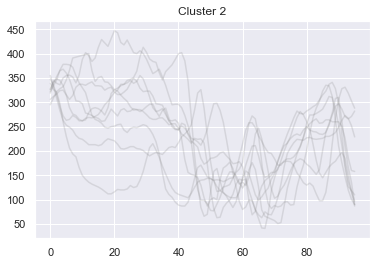

In [43]:
pintar_cluster_dtw_closest(df_train_day_pivoted, dtw_models[5], cluster=2, max_lines=9)

c:\users\jbart\anaconda3\lib\site-packages\tslearn\utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 565 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


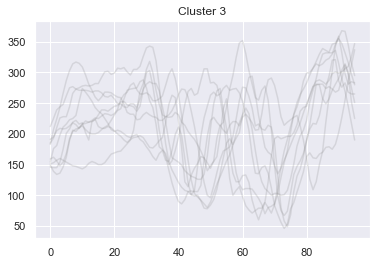

In [44]:
pintar_cluster_dtw_closest(df_train_day_pivoted, dtw_models[5], cluster=3, max_lines=9)

c:\users\jbart\anaconda3\lib\site-packages\tslearn\utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 565 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


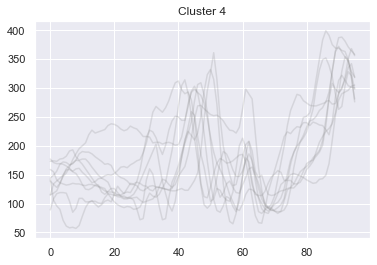

In [45]:
pintar_cluster_dtw_closest(df_train_day_pivoted, dtw_models[5], cluster=4, max_lines=9)

c:\users\jbart\anaconda3\lib\site-packages\tslearn\utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 565 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


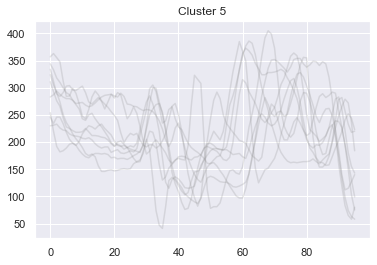

In [46]:
pintar_cluster_dtw_closest(df_train_day_pivoted, dtw_models[5], cluster=5, max_lines=9)